Phase 3 — Class Imbalance Handling (DEP_DEL15)

Goals:

• Inspect delay vs on-time imbalance on full 2015–2019 dataset (for context only)
• Apply class imbalance techniques only to the training split (2015–2017)
• Implement class weighting for models that support weightCol
• Implement undersampling of the majority class (optional)
• Leave validation (2018) and test (2019) untouched to preserve temporal integrity
• Ensure all imbalance methods avoid leakage by never using 2018–2019 in training

In [0]:

from pyspark.sql import functions as F

GROUP_PATH = "dbfs:/student-groups/Group_4_4"

# Base refined 5-year dataset (after feature refinement / removal)
PATH_CP5_5Y_REFINED = f"{GROUP_PATH}/checkpoint_5_final_clean_2015-2019_refined.parquet"

df_all = spark.read.parquet(PATH_CP5_5Y_REFINED)

# Recreate YEAR from FL_DATE if it was dropped in refinement
if "YEAR" not in df_all.columns:
    df_all = df_all.withColumn("YEAR", F.year("FL_DATE"))

print("Base refined dataset")
print("Rows:", df_all.count())
print("Columns:", len(df_all.columns))
print("Has DEP_DEL15:", "DEP_DEL15" in df_all.columns)
df_all.select("FL_DATE", "YEAR", "DEP_DEL15").show(5)

Base refined dataset
Rows: 31128891
Columns: 113
Has DEP_DEL15: True
+----------+----+---------+
|   FL_DATE|YEAR|DEP_DEL15|
+----------+----+---------+
|2015-01-01|2015|        0|
|2015-01-01|2015|        0|
|2015-01-01|2015|        0|
|2015-01-02|2015|        0|
|2015-01-02|2015|        0|
+----------+----+---------+
only showing top 5 rows


In [0]:
# Compute class distribution for DEP_DEL15 (delay vs on-time) on the full 2015–2019 dataset
class_counts_all = (
    df_all.groupBy("DEP_DEL15")
          .count()
          .orderBy("DEP_DEL15")
)

display(class_counts_all)

# Get total number of flights and counts for each class
total_all = df_all.count()
rows_all = class_counts_all.collect()

n0_all = next(r["count"] for r in rows_all if r["DEP_DEL15"] == 0)
n1_all = next(r["count"] for r in rows_all if r["DEP_DEL15"] == 1)

print(f"Total flights (2015–2019): {total_all:,}")
print(f"On-time (DEP_DEL15=0): {n0_all:,}  ({n0_all / total_all:.3%})")
print(f"Delayed (DEP_DEL15=1): {n1_all:,}  ({n1_all / total_all:.3%})")

# Split the dataset into train (2015–2017), validation (2018), and test (2019) sets
df_train = df_all.filter((F.col("YEAR") >= 2015) & (F.col("YEAR") <= 2017))
df_val   = df_all.filter(F.col("YEAR") == 2018)
df_test  = df_all.filter(F.col("YEAR") == 2019)

print("Train (2015–2017):", df_train.count())
print("Validation (2018):", df_val.count())
print("Test (2019):", df_test.count())

# Optional sanity check: show counts per year for each split
display(df_train.groupBy("YEAR").count().orderBy("YEAR"))
display(df_val.groupBy("YEAR").count().orderBy("YEAR"))
display(df_test.groupBy("YEAR").count().orderBy("YEAR"))

DEP_DEL15,count
0,25478089
1,5650802


Total flights (2015–2019): 31,128,891
On-time (DEP_DEL15=0): 25,478,089  (81.847%)
Delayed (DEP_DEL15=1): 5,650,802  (18.153%)
Train (2015–2017): 16804556
Validation (2018): 7065328
Test (2019): 7259007


YEAR,count
2015,5704114
2016,5529790
2017,5570652


YEAR,count
2018,7065328


YEAR,count
2019,7259007


In [0]:
def show_split_distribution(name, df):
    print(f"\n{name} split class distribution:")
    cc = (
        df.groupBy("DEP_DEL15")
          .count()
          .orderBy("DEP_DEL15")
    )
    display(cc)
    total = df.count()
    rows = cc.collect()
    n0 = next(r["count"] for r in rows if r["DEP_DEL15"] == 0)
    n1 = next(r["count"] for r in rows if r["DEP_DEL15"] == 1)
    print(f"  Total: {total:,}")
    print(f"  Class 0 (on-time): {n0:,} ({n0 / total:.3%})")
    print(f"  Class 1 (delayed): {n1:,} ({n1 / total:.3%})")

show_split_distribution("TRAIN (2015–2017)", df_train)
show_split_distribution("VALIDATION (2018)", df_val)
show_split_distribution("TEST (2019)", df_test)


TRAIN (2015–2017) split class distribution:


DEP_DEL15,count
0,13801920
1,3002636


  Total: 16,804,556
  Class 0 (on-time): 13,801,920 (82.132%)
  Class 1 (delayed): 3,002,636 (17.868%)

VALIDATION (2018) split class distribution:


DEP_DEL15,count
0,5768624
1,1296704


  Total: 7,065,328
  Class 0 (on-time): 5,768,624 (81.647%)
  Class 1 (delayed): 1,296,704 (18.353%)

TEST (2019) split class distribution:


DEP_DEL15,count
0,5907545
1,1351462


  Total: 7,259,007
  Class 0 (on-time): 5,907,545 (81.382%)
  Class 1 (delayed): 1,351,462 (18.618%)


In [0]:
train_counts = (
    df_train.groupBy("DEP_DEL15")
            .count()
            .orderBy("DEP_DEL15")
)

display(train_counts)

total_train = df_train.count()
rows_train = train_counts.collect()

n0_train = next(r["count"] for r in rows_train if r["DEP_DEL15"] == 0)
n1_train = next(r["count"] for r in rows_train if r["DEP_DEL15"] == 1)

w0 = total_train / (2.0 * n0_train)   # class 0 (on-time)
w1 = total_train / (2.0 * n1_train)   # class 1 (delayed)

print("Training class weights:")
print(f"  Class 0 (on-time):  {w0:.4f}")
print(f"  Class 1 (delayed):  {w1:.4f}")

df_train_weighted = df_train.withColumn(
    "class_weight",
    F.when(F.col("DEP_DEL15") == 1, F.lit(w1)).otherwise(F.lit(w0))
)

# Quick check
display(
    df_train_weighted.groupBy("DEP_DEL15")
                     .agg(
                         F.count("*").alias("count"),
                         F.avg("class_weight").alias("avg_weight")
                     )
                     .orderBy("DEP_DEL15")
)

DEP_DEL15,count
0,13801920
1,3002636


Training class weights:
  Class 0 (on-time):  0.6088
  Class 1 (delayed):  2.7983


DEP_DEL15,count,avg_weight
0,13801920,0.6087760253597484
1,3002636,2.7983005599034736


In [0]:
desired_ratio = 0.5  # target: delayed / on-time

# current ratio = n1_train / n0_train
# want: (n1_train) / (n0_train * frac_majority) ≈ desired_ratio
frac_majority = (n1_train / n0_train) / desired_ratio

fractions = {0: float(frac_majority), 1: 1.0}
print("Sampling fractions for undersampled train:", fractions)

df_train_undersampled = df_train.sampleBy(
    "DEP_DEL15",
    fractions=fractions,
    seed=42
)

show_split_distribution("TRAIN UNDERSAMPLED (2015–2017)", df_train_undersampled)

Sampling fractions for undersampled train: {0: 0.4351041014583478, 1: 1.0}

TRAIN UNDERSAMPLED (2015–2017) split class distribution:


DEP_DEL15,count
0,6006490
1,3002636


  Total: 9,009,126
  Class 0 (on-time): 6,006,490 (66.671%)
  Class 1 (delayed): 3,002,636 (33.329%)


In [0]:
TRAIN_PATH = f"{GROUP_PATH}/cp6_train_2015_2017_refined.parquet"
VAL_PATH   = f"{GROUP_PATH}/cp6_val_2018_refined.parquet"
TEST_PATH  = f"{GROUP_PATH}/cp6_test_2019_refined.parquet"

TRAIN_WEIGHTED_PATH     = f"{GROUP_PATH}/cp6_train_2015_2017_weighted.parquet"
TRAIN_UNDERSAMPLED_PATH = f"{GROUP_PATH}/cp6_train_2015_2017_undersampled_0_5_ratio.parquet"

# Save pure splits
df_train.write.mode("overwrite").parquet(TRAIN_PATH)
df_val.write.mode("overwrite").parquet(VAL_PATH)
df_test.write.mode("overwrite").parquet(TEST_PATH)

print("Saved TRAIN   →", TRAIN_PATH)
print("Saved VAL     →", VAL_PATH)
print("Saved TEST    →", TEST_PATH)

# Save imbalance-handled training variants
df_train_weighted.write.mode("overwrite").parquet(TRAIN_WEIGHTED_PATH)
df_train_undersampled.write.mode("overwrite").parquet(TRAIN_UNDERSAMPLED_PATH)

print("Saved WEIGHTED TRAIN     →", TRAIN_WEIGHTED_PATH)
print("Saved UNDERSAMPLED TRAIN →", TRAIN_UNDERSAMPLED_PATH)

Saved TRAIN   → dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet
Saved VAL     → dbfs:/student-groups/Group_4_4/cp6_val_2018_refined.parquet
Saved TEST    → dbfs:/student-groups/Group_4_4/cp6_test_2019_refined.parquet
Saved WEIGHTED TRAIN     → dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_weighted.parquet
Saved UNDERSAMPLED TRAIN → dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_undersampled_0_5_ratio.parquet


### Class Imbalance Across Splits

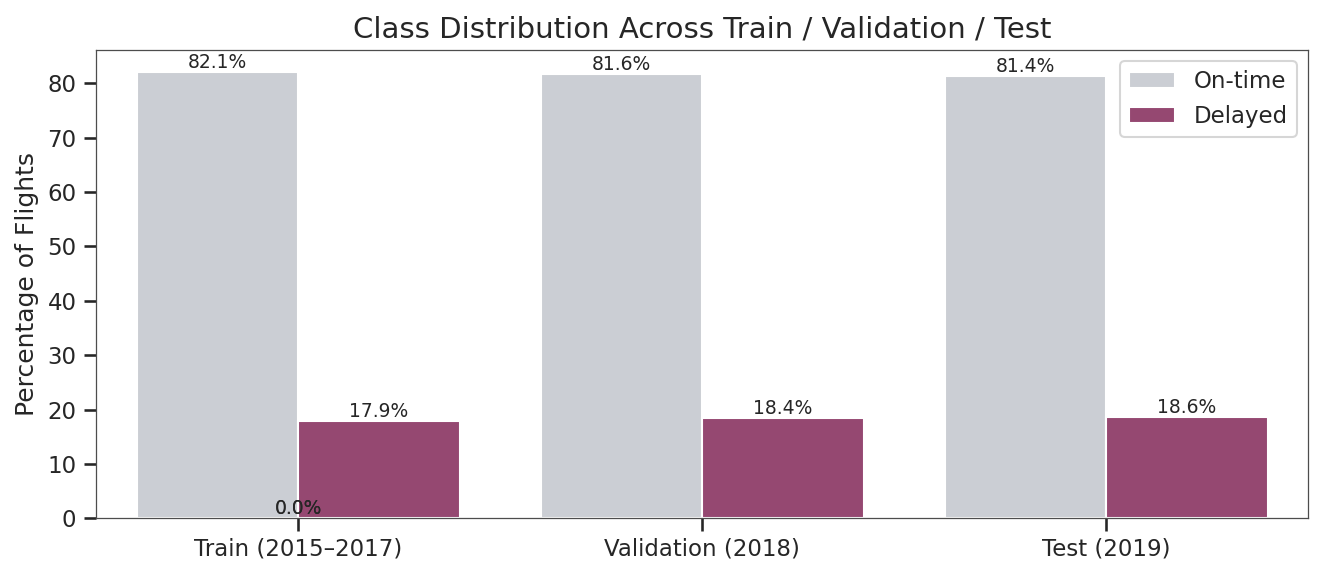

*Delay is consistently rare (~18%) across train, validation, and test — a naive 'always on-time' model reaches ~82% accuracy, which is why we optimize F₂ instead of raw accuracy.*

In [0]:
# ============================================================
# PHASE 3 — CLASS DISTRIBUTION ACROSS TRAIN / VAL / TEST
#   • Uses refined real splits (no rebalanced variants)
#   • Visual: On-time vs Delayed by split
# ============================================================

from IPython.display import display, Markdown, Image
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
import pandas as pd
import os


# -----------------------------
# Paths to refined splits
# -----------------------------
TRAIN_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet"
VAL_PATH   = "dbfs:/student-groups/Group_4_4/cp6_val_2018_refined.parquet"
TEST_PATH  = "dbfs:/student-groups/Group_4_4/cp6_test_2019_refined.parquet"

# Folder for charts (same pattern as other Phase 3 figures)
BASE = "/dbfs/student-groups/Group_4_4/Charts/phase3"
os.makedirs(BASE, exist_ok=True)

# -----------------------------
# Load splits
# -----------------------------
df_train = spark.read.parquet(TRAIN_PATH)
df_val   = spark.read.parquet(VAL_PATH)
df_test  = spark.read.parquet(TEST_PATH)

# -----------------------------
# Helper: class distribution
# -----------------------------
def get_class_distribution(df, split_label):
    """
    Returns a pandas DataFrame with columns:
    Split | Class | Percent
    where Class ∈ {"On-time", "Delayed"}
    """
    agg = (
        df.groupBy(F.col("DEP_DEL15").cast("int").alias("DEP_DEL15"))
          .count()
    )

    total = agg.agg(F.sum("count").alias("total")).collect()[0]["total"]

    pdf = agg.toPandas()
    pdf["Split"] = split_label
    pdf["Class"] = pdf["DEP_DEL15"].map({0: "On-time", 1: "Delayed"})
    pdf["Percent"] = pdf["count"] / total * 100

    return pdf[["Split", "Class", "Percent"]]

pdf_train = get_class_distribution(df_train, "Train (2015–2017)")
pdf_val   = get_class_distribution(df_val,   "Validation (2018)")
pdf_test  = get_class_distribution(df_test,  "Test (2019)")

pdf_all = pd.concat([pdf_train, pdf_val, pdf_test], ignore_index=True)

# -----------------------------
# Plot style (Phase 3-ish)
# -----------------------------
sns.set(style="ticks")
plt.rcParams.update({
    "axes.edgecolor": "0.3",
    "axes.linewidth": 0.6,
    "grid.color": "0.85",
    "grid.linewidth": 0.7,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

color_on_time = "#C9CED6"   # soft gray
color_delayed = "#A23B72"   # Flight Sentry accent

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 4))

sns.barplot(
    data=pdf_all,
    x="Split",
    y="Percent",
    hue="Class",
    hue_order=["On-time", "Delayed"],
    palette=[color_on_time, color_delayed],
    ax=ax,
)

# Add labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_title("Class Distribution Across Train / Validation / Test")
ax.set_xlabel("")
ax.set_ylabel("Percentage of Flights")

# Move legend
ax.legend(title="", loc="upper right")

plt.tight_layout()

# -----------------------------
# Save + display image
# -----------------------------
out_file = os.path.join(BASE, "panel_targets_splits.png")
fig.savefig(out_file, dpi=150, bbox_inches="tight")
plt.close(fig)

display(Markdown("### Class Imbalance Across Splits"))
display(Image(filename=out_file, width=850))

display(Markdown(
    "*Delay is consistently rare (~18%) across train, validation, and test — "
    "a naive 'always on-time' model reaches ~82% accuracy, which is why we "
    "optimize F₂ instead of raw accuracy.*"
))


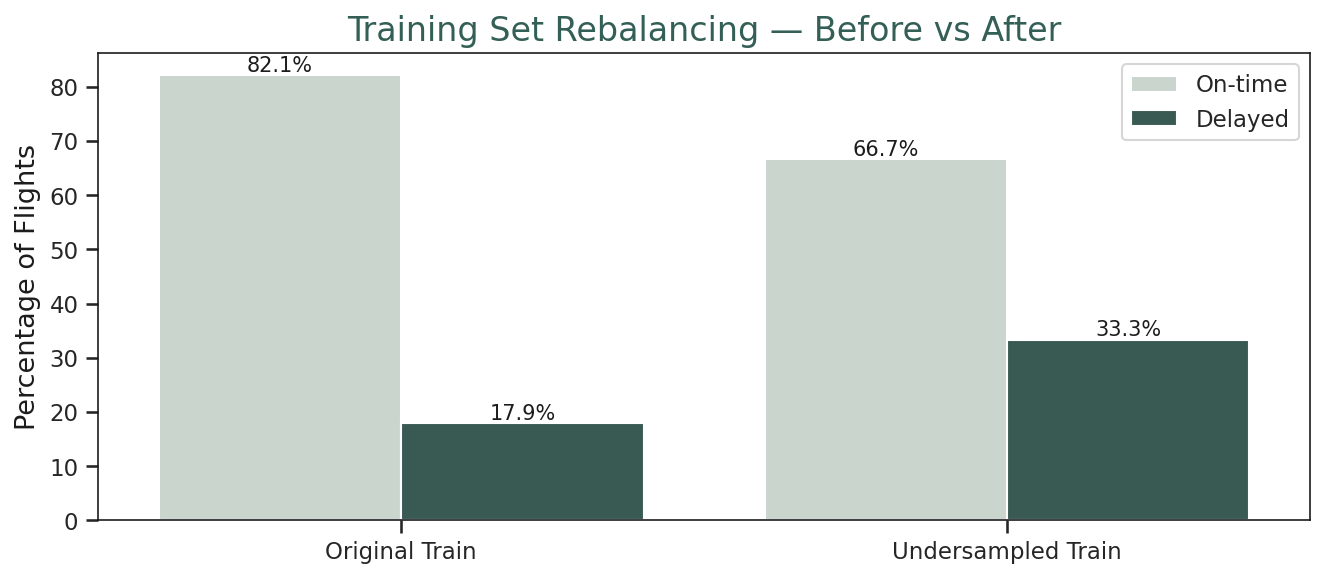

In [0]:
# ============================================================
# Improved Training Rebalance Figure (clean labels + better colors)
# ============================================================

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Image
import os

TRAIN_ORIG_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet"
TRAIN_UNDER_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_undersampled_0_5_ratio.parquet"

BASE = "/dbfs/student-groups/Group_4_4/Charts/phase3"
os.makedirs(BASE, exist_ok=True)

df_train_orig  = spark.read.parquet(TRAIN_ORIG_PATH)
df_train_under = spark.read.parquet(TRAIN_UNDER_PATH)

def get_class_distribution(df, label):
    agg = df.groupBy(F.col("DEP_DEL15").cast("int")).count()
    total = agg.agg(F.sum("count")).collect()[0][0]
    pdf = agg.toPandas()
    pdf["Dataset"] = label
    pdf["Class"] = pdf["DEP_DEL15"].map({0: "On-time", 1: "Delayed"})
    pdf["Percent"] = pdf["count"] / total * 100
    return pdf[["Dataset", "Class", "Percent"]]

pdf_all = pd.concat([
    get_class_distribution(df_train_orig,  "Original Train"),
    get_class_distribution(df_train_under, "Undersampled Train")
], ignore_index=True)

sns.set_style("ticks")
plt.rcParams.update({
    "axes.edgecolor": "#1C1C1C",
    "axes.linewidth": 0.8,
    "grid.color": "#DDE5E0",
    "axes.titlesize": 16,
    "axes.labelsize": 13,
})

# Updated shades to match slide theme
color_on_time = "#C8D7CE"   # improved sage tone
color_delayed = "#335F56"   # deep green-teal

fig, ax = plt.subplots(figsize=(9, 4))

sns.barplot(
    data=pdf_all,
    x="Dataset",
    y="Percent",
    hue="Class",
    hue_order=["On-time", "Delayed"],
    palette=[color_on_time, color_delayed],
    ax=ax,
)

# Annotate bar values, skipping zeros
for p in ax.patches:
    height = p.get_height()
    if height < 1:    # skip the stray zero bar
        continue
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2., height),
        ha="center", va="bottom", fontsize=10, color="#1C1C1C"
    )

ax.set_title("Training Set Rebalancing — Before vs After", color="#335F56")
ax.set_xlabel("")
ax.set_ylabel("Percentage of Flights", color="#1C1C1C")
ax.legend(title="", loc="upper right")

plt.tight_layout()

out_file = os.path.join(BASE, "panel_train_rebalance_clean.png")
fig.savefig(out_file, dpi=150, bbox_inches="tight")
plt.close(fig)

display(Image(filename=out_file, width=850))


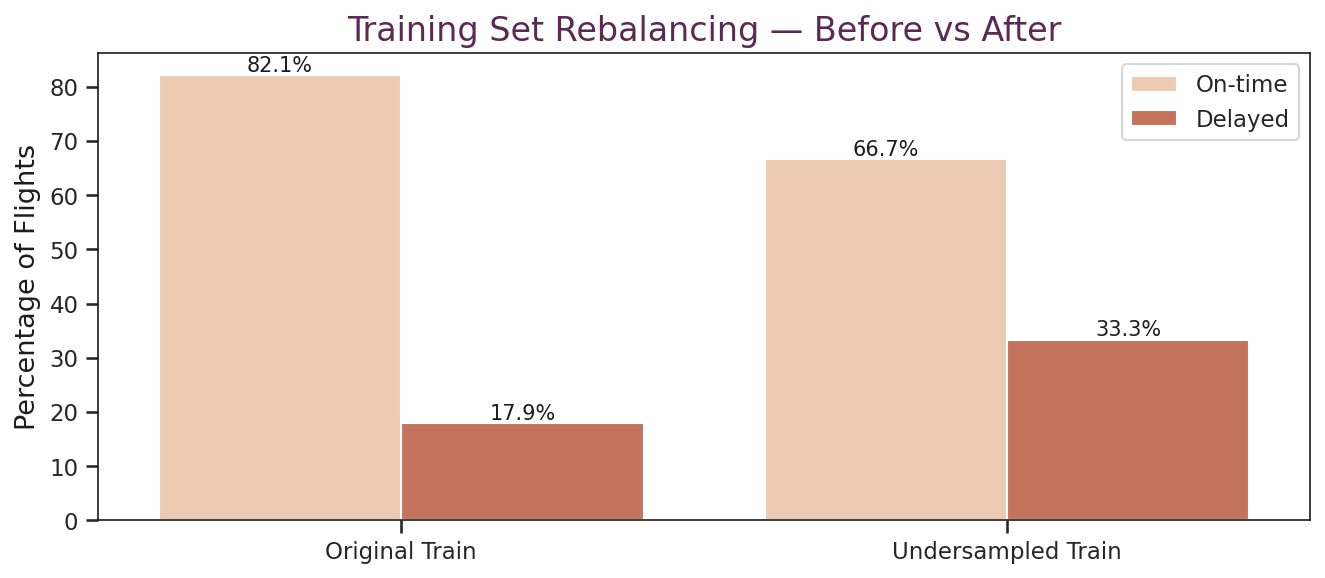

In [0]:
# ============================================================
# Training Rebalance Figure — Option A (Warm Greige + Deep Plum)
# ============================================================

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
import os

TRAIN_ORIG_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet"
TRAIN_UNDER_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_undersampled_0_5_ratio.parquet"

BASE = "/dbfs/student-groups/Group_4_4/Charts/phase3"
os.makedirs(BASE, exist_ok=True)

df_train_orig  = spark.read.parquet(TRAIN_ORIG_PATH)
df_train_under = spark.read.parquet(TRAIN_UNDER_PATH)

def get_class_distribution(df, label):
    agg = df.groupBy(F.col("DEP_DEL15").cast("int")).count()
    total = agg.agg(F.sum("count")).collect()[0][0]
    pdf = agg.toPandas()
    pdf["Dataset"] = label
    pdf["Class"] = pdf["DEP_DEL15"].map({0: "On-time", 1: "Delayed"})
    pdf["Percent"] = pdf["count"] / total * 100
    return pdf[["Dataset", "Class", "Percent"]]

pdf_all = pd.concat([
    get_class_distribution(df_train_orig,  "Original Train"),
    get_class_distribution(df_train_under, "Undersampled Train")
], ignore_index=True)

# -----------------------------
# Plot styling
# -----------------------------
sns.set_style("ticks")
plt.rcParams.update({
    "axes.edgecolor": "#1C1C1C",
    "axes.linewidth": 0.8,
    "grid.color": "#E1E1E1",
    "grid.linewidth": 0.7,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
})

# === Option A Palette ===
color_on_time = "#F7C9A9"
color_delayed = "#D66A4A"

fig, ax = plt.subplots(figsize=(9, 4))

sns.barplot(
    data=pdf_all,
    x="Dataset",
    y="Percent",
    hue="Class",
    hue_order=["On-time", "Delayed"],
    palette=[color_on_time, color_delayed],
    ax=ax,
)

# Annotate bars — skip zeros
for p in ax.patches:
    height = p.get_height()
    if height < 1:
        continue
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2., height),
        ha="center", va="bottom",
        fontsize=10,
        color="#1C1C1C"
    )

ax.set_title("Training Set Rebalancing — Before vs After", color="#5A2A55")
ax.set_xlabel("")
ax.set_ylabel("Percentage of Flights", color="#1C1C1C")
ax.legend(title="", loc="upper right")

plt.tight_layout()

out_file = os.path.join(BASE, "panel_train_rebalance_plum_greige.png")
fig.savefig(out_file, dpi=150, bbox_inches="tight")
plt.close(fig)

display(Image(filename=out_file, width=850))
